**PREPARING ENVIROMENT**

In [ ]:
#!pip install geemap

In [ ]:
# IMPORTING LIBRARIES
import ee
import pandas as pd
import gspread
from google.colab import auth, drive, files
import matplotlib.pyplot as plt
from oauth2client.client import GoogleCredentials
import numpy as np
#import geemap

# LINKS TO EARTH ENGINE DOCUMENTATION
# https://developers.google.com/earth-engine/apidocs
# https://colab.research.google.com/github/csaybar/EEwPython/blob/master/5_Reducer.ipynb#scrollTo=F5-4Y7H02uDW

In [ ]:
# AUTHENTICATING EARTH ENGINE
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=j4VqVhhmIl51m2BviVkZT1gIQpUaOGqkAuLa66I9BpI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5cln466gFc47mvqe8jnXYqhRMmfraD49s4rICGPzOGHCalsq4ct6Y

Successfully saved authorization token.


In [ ]:
# INTITIALIZING EARTH ENGINE
ee.Initialize()

# MOUNTING GOOGLE DRIVE
drive.mount('/content/drive')

Mounted at /content/drive


**CREATING FUNCTIONS**

In [ ]:
#def get_images(coordinates, dates):
#    # Creating empty lists

#    geo_list = []
#    b_sar_list = []
#    a_sar_list = []
#    b_landsat_list = []
#    a_landsat_list = []

    # Converting coordinates into ee geometry points
#    for i in range(0, len(coordinates)):
#        c = ee.Geometry.Point(coordinates[i])
#        g = c.buffer(1000)
#        geo_list.append(g)

#        md = ee.Date(dates[i])
#        sd = md.advance(-4, 'week')
#        ed = md.advance(4, 'week')

#        b_sar = ee.ImageCollection("COPERNICUS/S1_GRD_FLOAT").filterBounds(c).filterDate(sd, md).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).limit(1, 'system:time_start', False).first() 
#        a_sar = ee.ImageCollection("COPERNICUS/S1_GRD_FLOAT").filterBounds(c).filterDate(md, ed).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).first()
#        b_sar_list.append(b_sar)
#        a_sar_list.append(a_sar)
        
#        b_landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(c).filterDate(sd, md).sort('CLOUD_COVER').limit(1, 'system:time_start', False).first()
#        a_landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(c).filterDate(md, ed).sort('CLOUD_COVER').first()
#        b_landsat_list.append(b_landsat)
#        a_landsat_list.append(a_landsat)
    
#    return b_sar_list, a_sar_list, b_landsat_list, a_landsat_list, geo_list 

In [ ]:
reducers = ee.Reducer.mean().combine(**
                                     {'reducer2': ee.Reducer.stdDev(), 
                                      'sharedInputs': True}).combine(**
                                                                     {'reducer2': ee.Reducer.max(), 
                                                                      'sharedInputs': True}).combine(**
                                                                                                     {'reducer2':ee.Reducer.min(), 
                                                                                                      'sharedInputs':True}).combine(**
                                                                                                                                    {'reducer2': ee.Reducer.percentile([25, 50, 75]), 
                                                                                                                                     'sharedInputs':True})

In [ ]:
def det(im):
  return im.expression('b(0) * b(1)')
    
def chi2cdf(chi2, df):
  ''' Chi square cumulative distribution function for df degrees of freedom
  using the built-in incomplete gamma function gammainc() '''
  return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

def sar(before, after, geometry): 
  m = 5
  
  try:
    # The observed test statistic image -2logq
    m2logq = det(before).log().add(det(after).log()).subtract(det(before.add(after)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)
    
    # The P value image prob(m2logQ > m2logq) = 1 - prob(m2logQ < m2logq).
    p_value = ee.Image.constant(1).subtract(chi2cdf(m2logq, 2))
    
    c_map = p_value.multiply(0).where(p_value.lt(0.05), 1)
    
    diff = after.subtract(before) # Getting the difference between the two images
    d_map = c_map.multiply(0)                    # Initialize the direction map to zero.
    d_map = d_map.where(det(diff).gt(0), 1)      # All pos or neg def diffs are now labeled 1.
    d_map = d_map.where(diff.select(0).gt(0), 2) # Re-label pos def (and label some indef) to 2.
    d_map = d_map.where(det(diff).lt(0), 1)      # Label all indef to 1.
    c_map = c_map.multiply(d_map) # Re-label the c_map, 0*X = 0, 1*1 = 1, 1*2= 2, 1*3 = 3.

    stats = c_map.reduceRegion(**{'reducer':reducers, 'bestEffort':True, 'scale':30, 'geometry':geometry}).getInfo()
    mean = stats['constant_mean']
    stddev = stats['constant_stdDev']
    p25 = stats['constant_p25']
    p50 = stats['constant_p50']
    p75 = stats['constant_p75']
    min = stats['constant_min']
    max = stats['constant_max']
  except: 
    mean = None
    stddev = None
    p25 = None
    p50 = None
    p75 = None
    min = None
    max = None

  return p25, p50, p75, mean, stddev, min, max

def sar_difference(before, after, geometry):
  
  mean_list = []
  stddev_list = []
  p25_list = []
  p50_list = []
  p75_list = []
  min_list = []
  max_list = []
  
  for i in range(0, len(before), 1000):

    mean, stddev, p25, p50,p75, min, max = sar(before[i], after[i], geometry[i])

    mean_list.append(mean)
    stddev_list.append(stddev)
    p25_list.append(p25)
    p50_list.append(p50)
    p75_list.append(p75)
    min_list.append(min)
    max_list.append(max)

    print(f"Image {i} Done")

  sar_df = pd.DataFrame(list(zip(mean_list, stddev_list, p25_list, 
                                 p50_list, p75_list, min_list,max_list)), columns = ['SAR_mean', 'SAR_stdDev', 'SAR_p25', 
                                                                                    'SAR_p50', 'SAR_p75', 'SAR_min','SAR_max']) 

  return sar_df

In [ ]:
def ndvi(before, after, geometry):

  try:
    stats_b = before.normalizedDifference(['B5', 'B4']).rename('NDVI').reduceRegion(**{'reducer':reducers, 
                                                                                       'bestEffort':True, 'scale':30, 'geometry':geometry}).getInfo()
    stats_a = after.normalizedDifference(['B5', 'B4']).rename('NDVI').reduceRegion(**{'reducer':reducers, 
                                                                                      'bestEffort':True, 'scale':30, 'geometry':geometry}).getInfo()

    mean_b = stats_b['NDVI_mean']
    mean_a = stats_a['NDVI_mean']

    p25_b = stats_b['NDVI_p25']
    p25_a = stats_a['NDVI_p25']

    p50_b = stats_b['NDVI_p50']
    p50_a = stats_a['NDVI_p50']

    p75_b = stats_b['NDVI_p75']
    p75_a = stats_a['NDVI_p75']

    stddev_b = stats_b['NDVI_stdDev']
    stddev_a = stats_a['NDVI_stdDev']

    min_b = stats_b['NDVI_min']
    min_a = stats_a['NDVI_min']

    max_b = stats_b['NDVI_max']
    max_a = stats_a['NDVI_max']

    p25 = p25_a - p25_b * 100
    p50 = p50_a - p50_b * 100
    p75 = p75_a - p50_b * 100
    mean = mean_a - mean_b * 100
    min = min_a - min_b * 100
    max = max_a - max_b * 100
    stddev = stddev_a - stddev_b * 100 
  
  except: 
    p25 = None
    p50 = None
    p75 = None
    mean = None
    stddev = None
    min = None
    max = None
    
  return p25, p50, p75, mean, stddev, min, max

def ndvi_difference(before, after, geometry):
  p25_list = []
  p50_list = []
  p75_list = []
  mean_list = []
  stddev_list = []
  min_list = []
  max_list = []

  for i in range(0, len(before), 100):
      p25, p50, p75, mean, stddev, min, max = ndvi(before[i], after[i], geometry[i])
      p25_list.append(p25)
      p50_list.append(p50)
      p75_list.append(p75)
      mean_list.append(mean)
      stddev_list.append(stddev)
      min_list.append(min)
      max_list.append(max)

      print(f"mage {i} Done")

  ndvi_df = pd.DataFrame(list(zip(p25_list, p50_list, p75_list, 
                               mean_list, stddev_list, min_list, max_list)), columns = ['NDVI_p25', 'NDVI_p50', 'NDVI_p75', 
                                                                                        'NDVI_mean', 'NDVI_stdDev', 'NDVI_min', 'NDVI_max'])   
  return ndvi_df

In [ ]:
def nbr(before, after, geometry):

  try:
    stats_b = before.normalizedDifference(['B5', 'B7']).rename('NBR').reduceRegion(**{'reducer':reducers, 
                                                                                       'bestEffort':True, 'scale':30, 'geometry':geometry}).getInfo()
    stats_a = after.normalizedDifference(['B5', 'B7']).rename('NBR').reduceRegion(**{'reducer':reducers, 
                                                                                      'bestEffort':True, 'scale':30, 'geometry':geometry}).getInfo()

    mean_b = stats_b['NBR_mean']
    mean_a = stats_a['NBR_mean']

    p25_b = stats_b['NBR_p25']
    p25_a = stats_a['NBR_p25']

    p50_b = stats_b['NBR_p50']
    p50_a = stats_a['NBR_p50']

    p75_b = stats_b['NBR_p75']
    p75_a = stats_a['NBR_p75']

    stddev_b = stats_b['NBR_stdDev']
    stddev_a = stats_a['NBR_stdDev']

    min_b = stats_b['NBR_min']
    min_a = stats_a['NBR_min']

    max_b = stats_b['NBR_max']
    max_a = stats_a['NBR_max']

    p25 = p25_a - p25_b * 100
    p50 = p50_a - p50_b * 100
    p75 = p75_a - p50_b * 100
    mean = mean_a - mean_b * 100
    min = min_a - min_b * 100
    max = max_a - max_b * 100
    stddev = stddev_a - stddev_b * 100
  
  except: 
    p25 = None
    p50 = None
    p75 = None
    mean = None
    stddev = None
    min = None
    max = None
    
  return p25, p50, p75, mean, stddev, min, max

def nbr_difference(before, after, geometry):
  p25_list = []
  p50_list = []
  p75_list = []
  mean_list = []
  stddev_list = []
  min_list = []
  max_list = []

  for i in range(0, len(before)):
      p25, p50, p75, mean, stddev, min, max = nbr(before[i], after[i], geometry[i])
      p25_list.append(p25)
      p50_list.append(p50)
      p75_list.append(p75)
      mean_list.append(mean)
      stddev_list.append(stddev)
      min_list.append(min)
      max_list.append(max)

      print(f"Image {i} Done")

  nbr_df = pd.DataFrame(list(zip(p25_list, p50_list, p75_list, 
                               mean_list, stddev_list, min_list, max_list)), columns = ['NBR_p25', 'NBR_p50', 'NBR_p75', 
                                                                                        'NBR_mean', 'NBR_stdDev', 'NBR_min', 'NBR_max'])   
  return nbr_df

In [ ]:
def evi(before, after, geometry):

  try:
    before_evi = before.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': before.select('B5'),
        'RED': before.select('B4'),
        'BLUE': before.select('B2')
    })

    after_evi = after.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': after.select('B5'),
        'RED': after.select('B4'),
        'BLUE': after.select('B2')
    })

    stats_b = before_evi.rename('EVI').reduceRegion(**{'reducer':reducers, 'bestEffort':True, 'scale':30, 'geometry':geometry}).getInfo()
    stats_a = after_evi.rename('EVI').reduceRegion(**{'reducer':reducers, 'bestEffort':True, 'scale':30, 'geometry':geometry}).getInfo()

    mean_b = stats_b['EVI_mean']
    mean_a = stats_a['EVI_mean']

    p25_b = stats_b['EVI_p25']
    p25_a = stats_a['EVI_p25']

    p50_b = stats_b['EVI_p50']
    p50_a = stats_a['EVI_p50']

    p75_b = stats_b['EVI_p75']
    p75_a = stats_a['EVI_p75']

    stddev_b = stats_b['EVI_stdDev']
    stddev_a = stats_a['EVI_stdDev']

    min_b = stats_b['EVI_min']
    min_a = stats_a['EVI_min']

    max_b = stats_b['EVI_max']
    max_a = stats_a['EVI_max']

    p25 = p25_a - p25_b * 100
    p50 = p50_a - p50_b * 100
    p75 = p75_a - p50_b * 100
    mean = mean_a - mean_b * 100
    min = min_a - min_b * 100
    max = max_a - max_b * 100
    stddev = stddev_a - stddev_b * 100
  
  except: 
    p25 = None
    p50 = None
    p75 = None
    mean = None
    stddev = None
    min = None
    max = None
    
  return p25, p50, p75, mean, stddev, min, max

def evi_difference(before, after, geometry):
  p25_list = []
  p50_list = []
  p75_list = []
  mean_list = []
  stddev_list = []
  min_list = []
  max_list = []

  for i in range(0, len(before)):
      p25, p50, p75, mean, stddev, min, max = evi(before[i], after[i], geometry[i])
      p25_list.append(p25)
      p50_list.append(p50)
      p75_list.append(p75)
      mean_list.append(mean)
      stddev_list.append(stddev)
      min_list.append(min)
      max_list.append(max)

      print(f"mage {i} Done")

  evi_df = pd.DataFrame(list(zip(p25_list, p50_list, p75_list, 
                               mean_list, stddev_list, min_list, max_list)), columns = ['EVI_p25', 'EVI_p50', 'EVI_p75', 
                                                                                        'EVI_mean', 'EVI_stdDev', 'EVI_min', 'EVI_max'])   
  return evi_df

In [ ]:
#def difference(before_landsat, after_landsat, before_sar, after_sar, geometry):
#  ndvi_p25_list = []
#  ndvi_p50_list = []
#  ndvi_p75_list = []
#  ndvi_mean_list = []
#  ndvi_stddev_list = []
#  ndvi_min_list = []
#  ndvi_max_list = []

#  evi_p25_list = []
#  evi_p50_list = []
#  evi_p75_list = []
#  evi_mean_list = []
#  evi_stddev_list = []
#  evi_min_list = []
#  evi_max_list = []

#  sar_mean_list = []
#  sar_stddev_list = []
#  sar_p25_list = []
#  sar_p50_list = []
#  sar_p75_list = []
#  sar_min_list = []
#  sar_max_list = []

#  nbr_mean_list = []
#  nbr_stddev_list = []
#  nbr_p25_list = []
#  nbr_p50_list = []
#  nbr_p75_list = []
#  nbr_min_list = []
#  nbr_max_list = []

#  for i in range(0, len(geometry)):
#      ndvi_p25, ndvi_p50, ndvi_p75, ndvi_mean, ndvi_stddev, ndvi_min, ndvi_max = ndvi(before_landsat[i], after_landsat[i], geometry[i])
#      ndvi_p25_list.append(ndvi_p25)
#      ndvi_p50_list.append(ndvi_p50)
#      ndvi_p75_list.append(ndvi_p75)
#      ndvi_mean_list.append(ndvi_mean)
#      ndvi_stddev_list.append(ndvi_stddev)
#      ndvi_min_list.append(ndvi_min)
#      ndvi_max_list.append(ndvi_max)   

#      evi_p25, evi_p50, evi_p75, evi_mean, evi_stddev, evi_min, evi_max = evi(before_landsat[i], after_landsat[i], geometry[i])
#      evi_p25_list.append(evi_p25)
#      evi_p50_list.append(evi_p50)
#      evi_p75_list.append(evi_p75)
#      evi_mean_list.append(evi_mean)
#      evi_stddev_list.append(evi_stddev)
#      evi_min_list.append(evi_min)
#      evi_max_list.append(evi_max)

#      sar_p25, sar_p50, sar_p75, sar_mean, sar_stddev, sar_min, sar_max = sar(before_sar[i], after_sar[i], geometry[i])
#      sar_mean_list.append(sar_mean)
#      sar_stddev_list.append(sar_stddev)
#      sar_p25_list.append(sar_p25)
#      sar_p50_list.append(sar_p50)
#      sar_p75_list.append(sar_p75)
#      sar_min_list.append(sar_min)
#      sar_max_list.append(sar_max)

#      nbr_p25, nbr_p50, nbr_p75, nbr_mean, nbr_stddev, nbr_min, nbr_max = nbr(before_landsat[i], after_landsat[i], geometry[i])
#      nbr_mean_list.append(nbr_mean)
#      nbr_stddev_list.append(nbr_stddev)
#      nbr_p25_list.append(nbr_p25)
#      nbr_p50_list.append(nbr_p50)
#      nbr_p75_list.append(nbr_p75)
#      nbr_min_list.append(nbr_min)
#      nbr_max_list.append(nbr_max)

#      print(f"Image {i} Done")

#  df = pd.DataFrame(list(zip(ndvi_p25_list, ndvi_p50_list, ndvi_p75_list, ndvi_mean_list, ndvi_stddev_list, ndvi_min_list, ndvi_max_list,
#                             evi_p25_list, evi_p50_list, evi_p75_list, evi_mean_list, evi_stddev_list, evi_min_list, evi_max_list, 
#                             sar_mean_list, sar_stddev_list, sar_p25_list, sar_p50_list, sar_p75_list, sar_min_list, sar_max_list, 
#                             nbr_mean_list, nbr_stddev_list, nbr_p25_list, nbr_p50_list, nbr_p75_list, nbr_min_list, nbr_max_list)), 
#                    columns = ['NDVI_p25', 'NDVI_p50', 'NDVI_p75', 'NDVI_mean', 'NDVI_stdDev', 'NDVI_min','NDVI_max',
#                               'EVI_p25', 'EVI_p50', 'EVI_p75', 'EVI_mean', 'EVI_stdDev', 'EVI_min','EVI_max', 
#                               'SAR_mean', 'SAR_stdDev', 'SAR_p25', 'SAR_p50', 'SAR_p75', 'SAR_min', 'SAR_max', 
#                               'NBR_mean', 'NBR_stdDev', 'NBR_p25', 'NBR_p50', 'NBR_p75', 'NBR_min', 'NBR_max']) 

#  return df

In [ ]:
def get_images(coordinates_1, dates_1, coordinates_0, dates_0):
    # Creating empty lists

    geo_list_1 = []
    b_sar_list_1 = []
    a_sar_list_1 = []
    b_landsat_list_1 = []
    a_landsat_list_1 = []

    geo_list_0 = []
    b_sar_list_0 = []
    a_sar_list_0 = []
    b_landsat_list_0 = []
    a_landsat_list_0 = []

    # Converting coordinates into ee geometry points
    for i in range(0, len(coordinates_1)):
        c_1 = ee.Geometry.Point(coordinates_1[i])
        g_1 = c_1.buffer(1000)
        geo_list_1.append(g_1)

        md_1 = ee.Date(dates_1[i])
        sd_1 = md_1.advance(-4, 'week')
        ed_1 = md_1.advance(4, 'week')

        b_sar_1 = ee.ImageCollection("COPERNICUS/S1_GRD_FLOAT").filterBounds(c_1).filterDate(sd_1, md_1).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).limit(1, 'system:time_start', False).first() 
        a_sar_1 = ee.ImageCollection("COPERNICUS/S1_GRD_FLOAT").filterBounds(c_1).filterDate(md_1, ed_1).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).first()
        b_sar_list_1.append(b_sar_1)
        a_sar_list_1.append(a_sar_1)
        
        b_landsat_1 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(c_1).filterDate(sd_1, md_1).sort('CLOUD_COVER').limit(1, 'system:time_start', False).first()
        a_landsat_1 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(c_1).filterDate(md_1, ed_1).sort('CLOUD_COVER').first()
        b_landsat_list_1.append(b_landsat_1)
        a_landsat_list_1.append(a_landsat_1)

        c_0 = ee.Geometry.Point(coordinates_0[i])
        g_0 = c_0.buffer(1000)
        geo_list_0.append(g_0)

        md_0 = ee.Date(dates_0[i])
        sd_0 = md_0.advance(-4, 'week')
        ed_0 = md_0.advance(4, 'week')

        b_sar_0 = ee.ImageCollection("COPERNICUS/S1_GRD_FLOAT").filterBounds(c_0).filterDate(sd_0, md_0).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).limit(1, 'system:time_start', False).first() 
        a_sar_0 = ee.ImageCollection("COPERNICUS/S1_GRD_FLOAT").filterBounds(c_0).filterDate(md_0, ed_0).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).first()
        b_sar_list_0.append(b_sar_0)
        a_sar_list_0.append(a_sar_0)
        
        b_landsat_0 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(c_0).filterDate(sd_0, md_0).sort('CLOUD_COVER').limit(1, 'system:time_start', False).first()
        a_landsat_0 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(c_0).filterDate(md_0, ed_0).sort('CLOUD_COVER').first()
        b_landsat_list_0.append(b_landsat_0)
        a_landsat_list_0.append(a_landsat_0)
    
    return b_sar_list_1, a_sar_list_1, b_landsat_list_1, a_landsat_list_1, geo_list_1, b_sar_list_0, a_sar_list_0, b_landsat_list_0, a_landsat_list_0, geo_list_0 

In [ ]:
def difference(before_landsat_1, after_landsat_1, before_sar_1, after_sar_1, geometry_1, before_landsat_0, after_landsat_0, before_sar_0, after_sar_0, geometry_0):
  ndvi_p25_list_1 = []
  ndvi_p50_list_1 = []
  ndvi_p75_list_1 = []
  ndvi_mean_list_1 = []
  ndvi_stddev_list_1 = []
  ndvi_min_list_1 = []
  ndvi_max_list_1 = []

  evi_p25_list_1 = []
  evi_p50_list_1 = []
  evi_p75_list_1 = []
  evi_mean_list_1 = []
  evi_stddev_list_1 = []
  evi_min_list_1 = []
  evi_max_list_1 = []

  sar_mean_list_1 = []
  sar_stddev_list_1 = []
  sar_p25_list_1 = []
  sar_p50_list_1 = []
  sar_p75_list_1 = []
  sar_min_list_1 = []
  sar_max_list_1 = []

  nbr_mean_list_1 = []
  nbr_stddev_list_1 = []
  nbr_p25_list_1 = []
  nbr_p50_list_1 = []
  nbr_p75_list_1 = []
  nbr_min_list_1 = []
  nbr_max_list_1 = []

  ndvi_p25_list_0 = []
  ndvi_p50_list_0 = []
  ndvi_p75_list_0 = []
  ndvi_mean_list_0 = []
  ndvi_stddev_list_0 = []
  ndvi_min_list_0 = []
  ndvi_max_list_0 = []

  evi_p25_list_0 = []
  evi_p50_list_0 = []
  evi_p75_list_0 = []
  evi_mean_list_0 = []
  evi_stddev_list_0 = []
  evi_min_list_0 = []
  evi_max_list_0 = []

  sar_mean_list_0 = []
  sar_stddev_list_0 = []
  sar_p25_list_0 = []
  sar_p50_list_0 = []
  sar_p75_list_0 = []
  sar_min_list_0 = []
  sar_max_list_0 = []

  nbr_mean_list_0 = []
  nbr_stddev_list_0 = []
  nbr_p25_list_0 = []
  nbr_p50_list_0 = []
  nbr_p75_list_0 = []
  nbr_min_list_0 = []
  nbr_max_list_0 = []

  for i in range(0, len(geometry_1), 10):
      ndvi_p25_1, ndvi_p50_1, ndvi_p75_1, ndvi_mean_1, ndvi_stddev_1, ndvi_min_1, ndvi_max_1 = ndvi(before_landsat_1[i], after_landsat_1[i], geometry_1[i])
      ndvi_p25_list_1.append(ndvi_p25_1)
      ndvi_p50_list_1.append(ndvi_p50_1)
      ndvi_p75_list_1.append(ndvi_p75_1)
      ndvi_mean_list_1.append(ndvi_mean_1)
      ndvi_stddev_list_1.append(ndvi_stddev_1)
      ndvi_min_list_1.append(ndvi_min_1)
      ndvi_max_list_1.append(ndvi_max_1)  

      ndvi_p25_0, ndvi_p50_0, ndvi_p75_0, ndvi_mean_0, ndvi_stddev_0, ndvi_min_0, ndvi_max_0 = ndvi(before_landsat_0[i], after_landsat_0[i], geometry_0[i])
      ndvi_p25_list_0.append(ndvi_p25_0)
      ndvi_p50_list_0.append(ndvi_p50_0)
      ndvi_p75_list_0.append(ndvi_p75_0)
      ndvi_mean_list_0.append(ndvi_mean_0)
      ndvi_stddev_list_0.append(ndvi_stddev_0)
      ndvi_min_list_0.append(ndvi_min_0)
      ndvi_max_list_0.append(ndvi_max_0)  

      evi_p25_1, evi_p50_1, evi_p75_1, evi_mean_1, evi_stddev_1, evi_min_1, evi_max_1 = evi(before_landsat_1[i], after_landsat_1[i], geometry_1[i])
      evi_p25_list_1.append(evi_p25_1)
      evi_p50_list_1.append(evi_p50_1)
      evi_p75_list_1.append(evi_p75_1)
      evi_mean_list_1.append(evi_mean_1)
      evi_stddev_list_1.append(evi_stddev_1)
      evi_min_list_1.append(evi_min_1)
      evi_max_list_1.append(evi_max_1)

      evi_p25_0, evi_p50_0, evi_p75_0, evi_mean_0, evi_stddev_0, evi_min_0, evi_max_0 = evi(before_landsat_0[i], after_landsat_0[i], geometry_0[i])
      evi_p25_list_0.append(evi_p25_0)
      evi_p50_list_0.append(evi_p50_0)
      evi_p75_list_0.append(evi_p75_0)
      evi_mean_list_0.append(evi_mean_0)
      evi_stddev_list_0.append(evi_stddev_0)
      evi_min_list_0.append(evi_min_0)
      evi_max_list_0.append(evi_max_0)

      sar_p25_1, sar_p50_1, sar_p75_1, sar_mean_1, sar_stddev_1, sar_min_1, sar_max_1 = sar(before_sar_1[i], after_sar_1[i], geometry_1[i])
      sar_mean_list_1.append(sar_mean_1)
      sar_stddev_list_1.append(sar_stddev_1)
      sar_p25_list_1.append(sar_p25_1)
      sar_p50_list_1.append(sar_p50_1)
      sar_p75_list_1.append(sar_p75_1)
      sar_min_list_1.append(sar_min_1)
      sar_max_list_1.append(sar_max_1)

      sar_p25_0, sar_p50_0, sar_p75_0, sar_mean_0, sar_stddev_0, sar_min_0, sar_max_0 = sar(before_sar_0[i], after_sar_0[i], geometry_0[i])
      sar_mean_list_0.append(sar_mean_0)
      sar_stddev_list_0.append(sar_stddev_0)
      sar_p25_list_0.append(sar_p25_0)
      sar_p50_list_0.append(sar_p50_0)
      sar_p75_list_0.append(sar_p75_0)
      sar_min_list_0.append(sar_min_0)
      sar_max_list_0.append(sar_max_0)

      nbr_p25_1, nbr_p50_1, nbr_p75_1, nbr_mean_1, nbr_stddev_1, nbr_min_1, nbr_max_1 = nbr(before_landsat_1[i], after_landsat_1[i], geometry_1[i])
      nbr_mean_list_1.append(nbr_mean_1)
      nbr_stddev_list_1.append(nbr_stddev_1)
      nbr_p25_list_1.append(nbr_p25_1)
      nbr_p50_list_1.append(nbr_p50_1)
      nbr_p75_list_1.append(nbr_p75_1)
      nbr_min_list_1.append(nbr_min_1)
      nbr_max_list_1.append(nbr_max_1)

      nbr_p25_0, nbr_p50_0, nbr_p75_0, nbr_mean_0, nbr_stddev_0, nbr_min_0, nbr_max_0 = nbr(before_landsat_0[i], after_landsat_0[i], geometry_0[i])
      nbr_mean_list_0.append(nbr_mean_0)
      nbr_stddev_list_0.append(nbr_stddev_0)
      nbr_p25_list_0.append(nbr_p25_0)
      nbr_p50_list_0.append(nbr_p50_0)
      nbr_p75_list_0.append(nbr_p75_0)
      nbr_min_list_0.append(nbr_min_0)
      nbr_max_list_0.append(nbr_max_0)

      print(f"Image {i} Done")

  df_1 = pd.DataFrame(list(zip(ndvi_p25_list_1, ndvi_p50_list_1, ndvi_p75_list_1, ndvi_mean_list_1, ndvi_stddev_list_1, ndvi_min_list_1, ndvi_max_list_1,
                             evi_p25_list_1, evi_p50_list_1, evi_p75_list_1, evi_mean_list_1, evi_stddev_list_1, evi_min_list_1, evi_max_list_1, 
                             sar_mean_list_1, sar_stddev_list_1, sar_p25_list_1, sar_p50_list_1, sar_p75_list_1, sar_min_list_1, sar_max_list_1, 
                             nbr_mean_list_1, nbr_stddev_list_1, nbr_p25_list_1, nbr_p50_list_1, nbr_p75_list_1, nbr_min_list_1, nbr_max_list_1)), 
                    columns = ['NDVI_p25', 'NDVI_p50', 'NDVI_p75', 'NDVI_mean', 'NDVI_stdDev', 'NDVI_min','NDVI_max',
                               'EVI_p25', 'EVI_p50', 'EVI_p75', 'EVI_mean', 'EVI_stdDev', 'EVI_min','EVI_max', 
                               'SAR_mean', 'SAR_stdDev', 'SAR_p25', 'SAR_p50', 'SAR_p75', 'SAR_min', 'SAR_max', 
                               'NBR_mean', 'NBR_stdDev', 'NBR_p25', 'NBR_p50', 'NBR_p75', 'NBR_min', 'NBR_max']) 

  df_0 = pd.DataFrame(list(zip(ndvi_p25_list_0, ndvi_p50_list_0, ndvi_p75_list_0, ndvi_mean_list_0, ndvi_stddev_list_0, ndvi_min_list_0, ndvi_max_list_0,
                             evi_p25_list_0, evi_p50_list_0, evi_p75_list_0, evi_mean_list_0, evi_stddev_list_0, evi_min_list_0, evi_max_list_0, 
                             sar_mean_list_0, sar_stddev_list_0, sar_p25_list_0, sar_p50_list_0, sar_p75_list_0, sar_min_list_0, sar_max_list_0, 
                             nbr_mean_list_0, nbr_stddev_list_0, nbr_p25_list_0, nbr_p50_list_0, nbr_p75_list_0, nbr_min_list_0, nbr_max_list_0)), 
                    columns = ['NDVI_p25', 'NDVI_p50', 'NDVI_p75', 'NDVI_mean', 'NDVI_stdDev', 'NDVI_min','NDVI_max',
                               'EVI_p25', 'EVI_p50', 'EVI_p75', 'EVI_mean', 'EVI_stdDev', 'EVI_min','EVI_max', 
                               'SAR_mean', 'SAR_stdDev', 'SAR_p25', 'SAR_p50', 'SAR_p75', 'SAR_min', 'SAR_max', 
                               'NBR_mean', 'NBR_stdDev', 'NBR_p25', 'NBR_p50', 'NBR_p75', 'NBR_min', 'NBR_max']) 
  
  df_1['Event'] = 1
  df_0['Event'] = 0

  df = df_1.append(df_0)

  return df

**PROCESSING DATA**

In [ ]:
# IMPORTING ACLED DATA INTO PANDAS DATAFRAME
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet_1 = gc.open('2018-02-13-2021-02-17').sheet1

acled = pd.DataFrame(worksheet_1.get_all_records())

In [ ]:
#acled.columns
print(f"Regions:\n{acled['region'].unique()}")
print("\n")
print(f"Event Types:\n{acled['sub_event_type'].unique()}")

Regions:
['Middle East' 'South America' 'Northern Africa' 'Europe'
 'Caucasus and Central Asia' 'Eastern Africa' 'South Asia'
 'Western Africa' 'Southeast Asia' 'Middle Africa' 'North America'
 'East Asia' 'Central America' 'Southern Africa' 'Caribbean']


Event Types:
['Shelling/artillery/missile attack' 'Remote explosive/landmine/IED'
 'Air/drone strike' 'Grenade' 'Suicide bomb' 'Chemical weapon']


In [ ]:
# Removing Grenades and Chemical Weapons subtypes
acled_sub = acled.loc[(acled['sub_event_type'] == 'Shelling/artillery/missile attack') & (acled['year'] != 2021)]

In [ ]:
# CREATING NEW DATAFRAMES WITH LATITUDE AND LONGITUDE / DATES
locations = acled_sub[["latitude", "longitude"]]
dates = acled_sub["event_date"].str.split(expand=True)

# GETTING DATES DATAFRAME SET UP
dates.columns = ["day", "month", "year"]
cols = dates.columns.tolist()
cols = ["year", "month", "day"]
dates = dates[cols]

# REPLACING MONTHS WITH INTEGERS AND ADDING '0' TO DAY INTEGERS
dates['month'].mask(dates['month'] == 'January', '01', inplace=True)
dates['month'].mask(dates['month'] == 'February', '02', inplace=True)
dates['month'].mask(dates['month'] == 'March', '03', inplace=True)
dates['month'].mask(dates['month'] == 'April', '04', inplace=True)
dates['month'].mask(dates['month'] == 'May', '05', inplace=True)
dates['month'].mask(dates['month'] == 'June', '06', inplace=True)
dates['month'].mask(dates['month'] == 'July', '07', inplace=True)
dates['month'].mask(dates['month'] == 'August', '08', inplace=True)
dates['month'].mask(dates['month'] == 'September', '09', inplace=True)
dates['month'].mask(dates['month'] == 'October', '10', inplace=True)
dates['month'].mask(dates['month'] == 'November', '11', inplace=True)
dates['month'].mask(dates['month'] == 'December', '12', inplace=True)

dates['day'].mask(dates['day'] == '1', '01', inplace=True)
dates['day'].mask(dates['day'] == '2', '02', inplace=True)
dates['day'].mask(dates['day'] == '3', '03', inplace=True)
dates['day'].mask(dates['day'] == '4', '04', inplace=True)
dates['day'].mask(dates['day'] == '5', '05', inplace=True)
dates['day'].mask(dates['day'] == '6', '06', inplace=True)
dates['day'].mask(dates['day'] == '7', '07', inplace=True)
dates['day'].mask(dates['day'] == '8', '08', inplace=True)
dates['day'].mask(dates['day'] == '9', '09', inplace=True)

# THE DATES DATAFRAME IS NOW IN A FORMAT WE CAN USE FOR EARTH ENGINE
dates['date'] = dates[['year', 'month', 'day']].agg('-'.join, axis=1)
dates.drop(columns=['year', 'month', 'day'], inplace=True)

# JOINING DATES AND LOCATIONS INTO A SINGLE DATAFRAME
events = pd.concat([locations, dates], axis=1)

# GETTING COORDINATES AND DATES AS LISTS
dates_1 = events["date"].values.tolist()

# IMPORTING COORDINATES INTO EARTH ENGINE GEOMETRY TYPE
cols = ['longitude','latitude']
coordinates_1 = locations[cols].values.tolist()

**NON EVENTS**

In [ ]:
worksheet_0 = gc.open('random_points').sheet1

non_events = pd.DataFrame(worksheet_0.get_all_records())

In [ ]:
non_events.head()

OID_  CID    POINT_X    POINT_Y
0     1    0 -70.050150  12.604571
1     2    0 -69.884088  12.415973
2     3    0 -69.962241  12.487105
3     4    0 -70.043278  12.564056
4     5    0 -69.984484  12.530190

In [ ]:
non_events.drop(['OID_', 'CID'], axis=1, inplace=True)
non_events = non_events.sample(n=50000, random_state=1)
non_events = non_events.reset_index().drop('index', axis=1) 

In [ ]:
dates_0 = pd.date_range(start='2018-02-13', end= '2019-12-31', freq = 'D').to_series()
dates_0 = pd.DataFrame(dates_0).reset_index().drop(columns='index').rename(columns={0:'Date'})
dates_sample = dates_0.sample(n=50000, replace=True, random_state=0).astype(str)
non_events['Date'] = dates_sample['Date'].values

In [ ]:
# GETTING COORDINATES AND DATES AS LISTS
dates_0 = non_events["Date"].values.tolist()

# IMPORTING COORDINATES INTO EARTH ENGINE GEOMETRY TYPE
cols = ['POINT_X','POINT_Y'] 
coordinates_0 = non_events[cols].values.tolist()

In [ ]:
before_sar_1, after_sar_1, before_landsat_1, after_landsat_1, geometries_1, before_sar_0, after_sar_0, before_landsat_0, after_landsat_0, geometries_0 = get_images(coordinates_1, dates_1, 
                                                                                                                                                                    coordinates_0, dates_0)

In [ ]:
data = difference(before_landsat_1, after_landsat_1, before_sar_1, after_sar_1, geometries_1, 
                  before_landsat_0, after_landsat_0, before_sar_0, after_sar_0, geometries_0)

Image 0 Done
Image 10 Done
Image 20 Done
Image 30 Done
Image 40 Done
Image 50 Done
Image 60 Done
Image 70 Done
Image 80 Done
Image 90 Done
Image 100 Done
Image 110 Done
Image 120 Done
Image 130 Done
Image 140 Done
Image 150 Done
Image 160 Done
Image 170 Done
Image 180 Done
Image 190 Done
Image 200 Done
Image 210 Done
Image 220 Done
Image 230 Done
Image 240 Done
Image 250 Done
Image 260 Done
Image 270 Done
Image 280 Done
Image 290 Done
Image 300 Done
Image 310 Done
Image 320 Done
Image 330 Done
Image 340 Done
Image 350 Done
Image 360 Done
Image 370 Done
Image 380 Done
Image 390 Done
Image 400 Done
Image 410 Done
Image 420 Done
Image 430 Done
Image 440 Done
Image 450 Done
Image 460 Done
Image 470 Done
Image 480 Done
Image 490 Done
Image 500 Done
Image 510 Done
Image 520 Done
Image 530 Done
Image 540 Done
Image 550 Done
Image 560 Done
Image 570 Done
Image 580 Done
Image 590 Done
Image 600 Done
Image 610 Done
Image 620 Done
Image 630 Done
Image 640 Done
Image 650 Done
Image 660 Done
Image 

In [ ]:
#data.to_csv('/content/drive/My Drive/data.csv')

In [ ]:
data.head(10)

NDVI_p25   NDVI_p50   NDVI_p75  ...    NBR_p75    NBR_min    NBR_max  Event
2    2  -0.684597  -0.830478  -0.787800  ... -29.366378 -21.560816 -33.973603      1
3    3  -0.169739  -0.269642  -0.214493  ... -30.488939 -28.013397 -33.038031      1
5    5  -9.484709 -11.017696 -11.006146  ...   5.241822  21.964932 -28.471614      1
6    6 -26.896413 -31.882609 -31.792851  ... -22.524112  -1.239030 -57.868579      1
8    8  -0.400473  -0.687584  -0.624806  ... -28.054378 -19.553179 -45.558204      1
9    9 -12.214589 -16.516576 -16.499162  ...  -3.309452  19.361210 -56.233463      1
10  10 -11.319616 -12.283269 -12.274475  ...  -3.575559   5.402442 -43.201189      1
11  11   0.410118   0.363294   0.418576  ... -35.840406 -32.733901 -39.637273      1
12  12  -6.630041  -7.976386  -7.894038  ... -23.056097 -15.852315 -29.888905      1
13  13 -14.841615 -17.855584 -17.769053  ... -12.131899  21.527773 -48.495125      1

[10 rows x 30 columns]

**MACHINE LEARNING**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, MiniBatchSparsePCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import scipy
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

In [ ]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet_2 = gc.open('data').sheet1

data = pd.DataFrame(worksheet_2.get_all_records())

In [ ]:
cols = data.columns
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
data

NDVI_p25   NDVI_p50  ...    NBR_min    NBR_max  Event
0        0        NaN        NaN  ...        NaN        NaN      1
1        1        NaN        NaN  ...        NaN        NaN      1
2        2  -0.684597  -0.830478  ... -21.560816 -33.973603      1
3        3  -0.169739  -0.269642  ... -28.013397 -33.038031      1
4        4        NaN        NaN  ...        NaN        NaN      1
...    ...        ...        ...  ...        ...        ...    ...
9685  4840 -28.748641 -33.572037  ...   6.670879 -24.838556      0
9686  4841 -80.213114 -87.234294  ... -13.621476 -83.602823      0
9687  4842        NaN        NaN  ...        NaN        NaN      0
9688  4843        NaN        NaN  ...        NaN        NaN      0
9689  4844  -0.738169  -1.479207  ...  -0.772429 -70.876513      0

[9690 rows x 30 columns]

In [ ]:
data.columns

Index(['', 'NDVI_p25', 'NDVI_p50', 'NDVI_p75', 'NDVI_mean', 'NDVI_stdDev',
       'NDVI_min', 'NDVI_max', 'EVI_p25', 'EVI_p50', 'EVI_p75', 'EVI_mean',
       'EVI_stdDev', 'EVI_min', 'EVI_max', 'SAR_mean', 'SAR_stdDev', 'SAR_p25',
       'SAR_p50', 'SAR_p75', 'SAR_min', 'SAR_max', 'NBR_mean', 'NBR_stdDev',
       'NBR_p25', 'NBR_p50', 'NBR_p75', 'NBR_min', 'NBR_max', 'Event'],
      dtype='object')

In [ ]:
data.drop(columns='', inplace=True)

In [ ]:
data.isnull().sum()

NDVI_p25       1319
NDVI_p50       1319
NDVI_p75       1319
NDVI_mean      1319
NDVI_stdDev    1319
NDVI_min       1319
NDVI_max       1319
EVI_p25        1318
EVI_p50        1318
EVI_p75        1318
EVI_mean       1318
EVI_stdDev     1318
EVI_min        1318
EVI_max        1318
SAR_mean       1287
SAR_stdDev     1287
SAR_p25        1287
SAR_p50        1287
SAR_p75        1287
SAR_min        1287
SAR_max        1287
NBR_mean       1319
NBR_stdDev     1319
NBR_p25        1319
NBR_p50        1319
NBR_p75        1319
NBR_min        1319
NBR_max        1319
Event             0
dtype: int64

In [ ]:
data.dropna(how='any', axis=0, inplace=True)

In [ ]:
data.skew()

NDVI_p25       -1.003666
NDVI_p50       -0.836772
NDVI_p75       -0.837202
NDVI_mean      -0.736280
NDVI_stdDev    -1.367157
NDVI_min        1.894133
NDVI_max        0.293694
EVI_p25         2.728693
EVI_p50        -0.350453
EVI_p75        -0.346131
EVI_mean       -0.210057
EVI_stdDev     -3.918180
EVI_min         4.130771
EVI_max        -4.142280
SAR_mean        3.420151
SAR_stdDev      1.081530
SAR_p25        22.739810
SAR_p50         8.846256
SAR_p75         3.653191
SAR_min         0.000000
SAR_max        -8.181467
NBR_mean       -0.445726
NBR_stdDev     -0.810505
NBR_p25        -0.689118
NBR_p50        -0.559497
NBR_p75        -0.561484
NBR_min         0.330513
NBR_max         0.516528
Event          -0.085328
dtype: float64

In [ ]:
print(len(data[data['Event'] == 1]))
print(len(data[data['Event'] == 0]))

3841
3527


In [ ]:
data.head(1)

NDVI_p25  NDVI_p50  NDVI_p75  ...    NBR_min    NBR_max  Event
2 -0.684597 -0.830478   -0.7878  ... -21.560816 -33.973603      1

[1 rows x 29 columns]

In [ ]:
x = data.iloc[:, :-2]
y = data.iloc[:, -1]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

In [ ]:
feat_select = RandomForestClassifier().fit(x_train, y_train)

pi = permutation_importance(feat_select, x_test, y_test, n_repeats=30, random_state=1)

for i in pi.importances_mean.argsort()[::-1]:
    print(f"{x_train.columns[i]} : {pi.importances_mean[i]:.3f}")

NDVI_max : 0.053
NDVI_min : 0.026
NBR_min : 0.020
NBR_mean : 0.010
NBR_p25 : 0.009
EVI_mean : 0.007
NBR_stdDev : 0.007
NDVI_p75 : 0.006
EVI_p25 : 0.006
NBR_p75 : 0.006
EVI_p50 : 0.006
NDVI_p25 : 0.005
SAR_mean : 0.005
NBR_p50 : 0.004
EVI_stdDev : 0.004
NDVI_mean : 0.004
EVI_p75 : 0.004
NDVI_p50 : 0.003
EVI_max : 0.003
SAR_stdDev : 0.002
EVI_min : 0.002
SAR_max : 0.001
NDVI_stdDev : 0.000
SAR_p25 : 0.000
SAR_p50 : 0.000
SAR_min : 0.000
SAR_p75 : -0.001


In [ ]:
x_train.drop(columns=['SAR_p75', 'SAR_min', 'SAR_p50', 'SAR_p25', 'NDVI_stdDev'], inplace=True)
x_test.drop(columns=['SAR_p75', 'SAR_min', 'SAR_p50', 'SAR_p25', 'NDVI_stdDev'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
x_train.columns

Index(['NDVI_p25', 'NDVI_p50', 'NDVI_p75', 'NDVI_mean', 'NDVI_min', 'NDVI_max',
       'EVI_p25', 'EVI_p50', 'EVI_p75', 'EVI_mean', 'EVI_stdDev', 'EVI_min',
       'EVI_max', 'SAR_mean', 'SAR_stdDev', 'SAR_max', 'NBR_mean',
       'NBR_stdDev', 'NBR_p25', 'NBR_p50', 'NBR_p75', 'NBR_min'],
      dtype='object')

In [ ]:
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.transform(x_test)

In [ ]:
pca = PCA(n_components = 14, random_state=1)
#pca = MiniBatchSparsePCA(n_components=10)
x_train_pca = pca.fit_transform(x_train_scale)
x_test_pca = pca.transform(x_test_scale)

In [ ]:
sum(pca.explained_variance_ratio_)

0.9968360859890246

In [ ]:
#scaler = StandardScaler()
#x_train_scale = scaler.fit_transform(x_train)
#x_test_scale = scaler.transform(x_test)

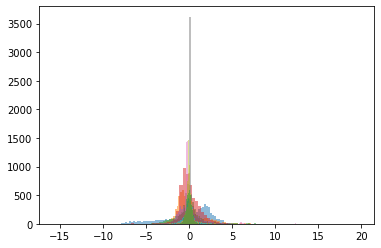

In [ ]:
plt.hist(x_train_pca[:,0].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,1].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,2].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,3].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,4].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,5].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,6].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,7].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,8].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,9].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,10].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,11].ravel(), bins=100, alpha=.5)
plt.hist(x_train_pca[:,12].ravel(), bins=100, alpha=.5)

plt.show()

In [ ]:
lin_svc = LinearSVC(random_state=0, max_iter=100000000)
knc = KNeighborsClassifier()
svm = BaggingClassifier(base_estimator=SVC(random_state=0, class_weight='balanced'), max_samples = .1, bootstrap=False)

In [ ]:
lin_svc.fit(x_train_pca, y_train)
lin_svc.score(x_test_pca, y_test)

0.6948968512486428

In [ ]:
knc.fit(x_train_pca, y_train)
knc.score(x_test_pca, y_test)

0.7633007600434311

In [ ]:
svm.fit(x_train_pca, y_train)
svm.score(x_test_pca, y_test)

0.7366992399565689

In [ ]:
hidden_layer_sizes = (400, 200)
activation = 'relu'
solver = 'sgd'
alpha = 0.01
batch_size = 50
learning_rate = 'adaptive'
learning_rate_init = 0.1
max_iter = 500
mlp = MLPClassifier(hidden_layer_sizes, activation, solver, alpha, batch_size, learning_rate, learning_rate_init, max_iter, random_state=0, early_stopping=True, n_iter_no_change=5)

mlp.fit(x_train_pca, y_train)
mlp.score(x_test_pca, y_test)

0.7975027144408252

In [ ]:
classifier = Pipeline([('Scale', StandardScaler()), 
                       ('PCA', PCA(n_components = 14, random_state=1)), 
                        ('Classifier', MLPClassifier((400,200), 'relu', 'sgd', 0.01, 50, 'adaptive', 0.1, max_iter, random_state=0, early_stopping=True, n_iter_no_change=5))])

In [ ]:
x.drop(columns=['SAR_p75', 'SAR_min', 'SAR_p50', 'SAR_p25', 'NDVI_stdDev'], inplace=True)

In [ ]:
x

NDVI_p25   NDVI_p50   NDVI_p75  ...    NBR_p50    NBR_p75    NBR_min
2     -0.684597  -0.830478  -0.787800  ... -29.417317 -29.366378 -21.560816
3     -0.169739  -0.269642  -0.214493  ... -30.559345 -30.488939 -28.013397
5     -9.484709 -11.017696 -11.006146  ...   5.222306   5.241822  21.964932
6    -26.896413 -31.882609 -31.792851  ... -22.602437 -22.524112  -1.239030
8     -0.400473  -0.687584  -0.624806  ... -28.124784 -28.054378 -19.553179
...         ...        ...        ...  ...        ...        ...        ...
9683   0.743761   0.489451   0.491527  ... -32.353477 -32.343765 -24.973668
9684   1.136763   0.918802   0.920819  ... -62.839592 -62.832988 -49.996309
9685 -28.748641 -33.572037 -33.548614  ... -11.911633 -11.884350   6.670879
9686 -80.213114 -87.234294 -87.214605  ... -70.225438 -70.201959 -13.621476
9689  -0.738169  -1.479207  -1.442214  ... -33.621603 -33.574901  -0.772429

[7368 rows x 22 columns]

In [ ]:
x.columns

Index(['NDVI_p25', 'NDVI_p50', 'NDVI_p75', 'NDVI_mean', 'NDVI_min', 'NDVI_max',
       'EVI_p25', 'EVI_p50', 'EVI_p75', 'EVI_mean', 'EVI_stdDev', 'EVI_min',
       'EVI_max', 'SAR_mean', 'SAR_stdDev', 'SAR_max', 'NBR_mean',
       'NBR_stdDev', 'NBR_p25', 'NBR_p50', 'NBR_p75', 'NBR_min'],
      dtype='object')

In [ ]:
classifier.fit(x, y)

Pipeline(memory=None,
         steps=[('Scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=13,
                     random_state=1, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('Classifier',
                 MLPClassifier(activation='relu', alpha=0.01, batch_size=50,
                               beta_1=0.9, beta_2=0.999, early_stopping=True,
                               epsilon=1e-08, hidden_layer_sizes=(400, 200),
                               learning_rate='adaptive', learning_rate_init=0.1,
                               max_fun=15000, max_iter=200, momentum=0.9,
                               n_iter_no_change=5, nesterovs_momentum=True,
                               power_t=500, random_state=0, shuffle=True,
                               solver='sgd', tol=0.0001,
                               validation_fraction=0.

In [ ]:
classifier.score(x, y)

0.8065960912052117

In [ ]:
import pickle
s = pickle.dumps(classifier)

In [ ]:
s

b'\x80\x03csklearn.pipeline\nPipeline\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00stepsq\x03]q\x04(X\x05\x00\x00\x00Scaleq\x05csklearn.preprocessing._data\nStandardScaler\nq\x06)\x81q\x07}q\x08(X\t\x00\x00\x00with_meanq\t\x88X\x08\x00\x00\x00with_stdq\n\x88X\x04\x00\x00\x00copyq\x0b\x88X\x0f\x00\x00\x00n_samples_seen_q\x0ccnumpy.core.multiarray\nscalar\nq\rcnumpy\ndtype\nq\x0eX\x02\x00\x00\x00i8q\x0f\x89\x88\x87q\x10Rq\x11(K\x03X\x01\x00\x00\x00<q\x12NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00tq\x13bC\x08\xc8\x1c\x00\x00\x00\x00\x00\x00q\x14\x86q\x15Rq\x16X\x05\x00\x00\x00mean_q\x17cnumpy.core.multiarray\n_reconstruct\nq\x18cnumpy\nndarray\nq\x19K\x00\x85q\x1aC\x01bq\x1b\x87q\x1cRq\x1d(K\x01K\x16\x85q\x1eh\x0eX\x02\x00\x00\x00f8q\x1f\x89\x88\x87q Rq!(K\x03h\x12NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00tq"b\x89C\xb0s\xf3\x05\x92_\xc85\xc0\x98\x92or\xac\x1e;\xc0\xba,\xa9\x98N\x0f;\xc0@\xb5G^:Y;\xc0\xd5\xce\xf7\x88\xf6\x0c\x0e\xc0\xbc\xe4\x8du\x85IK\xc0\x9e]i_\x1a\x99;\xc0l\x9f\x16\r\xa4\xaaR\

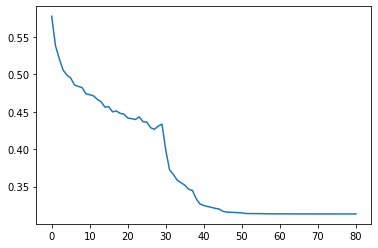

In [ ]:
plt.plot(mlp.loss_curve_)

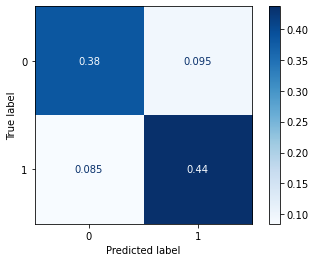

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp, x_test_pca, y_test, normalize='all', cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report
pred = mlp.predict(x_test_pca)
pd.DataFrame(classification_report(y_test, pred, output_dict=True)).transpose()

precision    recall  f1-score      support
0              0.819235  0.801587  0.810315   882.000000
1              0.821246  0.837500  0.829293   960.000000
accuracy       0.820304  0.820304  0.820304     0.820304
macro avg      0.820241  0.819544  0.819804  1842.000000
weighted avg   0.820283  0.820304  0.820206  1842.000000

In [ ]:
#from keras.layers import Input, Dense, BatchNormalization, Dropout
#from keras.models import Model
#from keras.metrics import BinaryAccuracy, BinaryCrossentropy

In [ ]:
#n_feat = x_train_pca.shape[1]
#input_layer = Input(shape=(n_feat))

#l1 = Dense(200, activation='relu', kernel_regularizer='l2')(input_layer)
#l2 = Dense(100, activation='relu', kernel_regularizer='l2')(l1)
#l3 = Dense(50, activation='relu', kernel_regularizer='l2')(l2)
#l3b = BatchNormalization(l3)
#l3d = Dropout(0.15)(l3b)
#l4 = Dense(25, activation='relu', kernel_regularizer='l2')(l3)
#l5 = Dense(10, activation='relu', kernel_regularizer='l2')(l4)
#l6 = Dense(5, activation='relu', kernel_regularizer='l2')(l5)
#l6b = BatchNormalization(l5)
#l6d = Dropout(0.15)(l6b)

#output_layer = Dense(1, activation='relu')(l6d)
#dnn = Model(input_layer, output_layer)

In [ ]:
#from keras.optimizers import Adam, SGD, Adagrad, Adamax, Nadam
#batch_size = 50 
#learn_rate = 0.0001
#opt = Nadam(lr=learn_rate)
#epochs = 250

#dnn.compile(loss='categorical_hinge', optimizer=opt, metrics='accuracy')

In [ ]:
#history = dnn.fit(x_train_pca, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.20)

In [ ]:
#history.history.keys()

In [ ]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model Loss')
#plt.ylabel('Loss')
#plt.xlabel('Number of Epochs')
#plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
#plt.show()

In [ ]:
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model Accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Number of Epochs')
#plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'lower right')
#plt.show()

**bold text**

In [ ]:
!pip install geemap
import geemap

     |████████████████████████████████| 450kB 13.2MB/s 
     |████████████████████████████████| 225kB 26.9MB/s 
     |████████████████████████████████| 5.1MB 31.2MB/s 
     |████████████████████████████████| 1.6MB 40.7MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 102kB 8.4MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 1.3MB 62.9MB/s 
     |████████████████████████████████| 1.2MB 69.8MB/s 
     |████████████████████████████████| 143kB 63.8MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 378kB 60.9MB/s 
     |████████████████████████████████| 122kB 61.5MB/s 
     |████████████████████████████████| 552kB 53.4MB/s 
     |████████████████████████████████| 122kB 62.9MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 430kB 58.5MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-non

In [ ]:
Map = geemap.Map()
Map

In [ ]:
geemap.ee_search()

NameError: ignored

In [ ]:
sentinel = ee.ImageCollection("COPERNICUS/S1_GRD_FLOAT").filterDate('2021-01-01', '2021-04-01')
landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterDate('2021-01-01', '2021-04-01')

In [ ]:
def bufferPoints(point):
  pt = ee.Feature(pt)
  return pt.buffer(radius)

In [ ]:
sentinel.evaluate

In [ ]:
Map.addLayer(sentinel, name='Sentinel 2')
Map.addLayer(landsat, name='Landsat 8')

In [ ]:
Map

EXTRAS